In [1]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os


In [2]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [3]:
from masa_utils import PsuedoLog
from masa_utils import InducedPolarization
from masa_utils import debye_res_t
from masa_utils_pytorch import Pelton_res_f
from masa_utils_pytorch import Pelton_con_f
from masa_utils_pytorch import InducedPolarizationSimulation
from masa_utils_pytorch import Optimization

# Debey Model resistivity form

In [4]:
tstrt = 0
tend = 16.0
ntime = 2**20
print(ntime)
tstep = (tend - tstrt) / ntime
ftesp = 1 / tend
times = np.arange(tstrt, tend, tstep)
freq = np.fft.fftfreq(ntime, tstep)

1048576


In [5]:
res0= 0.2
con8 = 2.0
eta= 0.5
tau= 0.1 #0.001
expc=1.0
parm_true = torch.tensor([np.log(res0), eta, np.log(tau), expc], dtype=torch.float32, requires_grad=False)
ip_model = Pelton_res_f(freq=freq)
sim = InducedPolarizationSimulation(ip_model=ip_model,times=times, mode="sip_t")
print(sim.ip_model)

In [6]:
# logstrt = -4
# logend = 0
# logstep =0.1
# windows_cen = 10**np.arange(logstrt,logend,logstep)
# nwindows = windows_cen.shape[0]
# print(windows_cen)
# sim.get_windows(windows_cen)

# print(sim.windows_strt)
# print(sim.windows_end)


In [7]:
logstrt = -2
logend = 0
logstep =0.1
windows_cen = np.r_[0, 10**np.arange(logstrt,logend,logstep)]
nwindows = windows_cen.shape[0]

sim.get_windows(windows_cen)
windows_strt = sim.windows_strt
windows_end = sim.windows_end
windows_strt[:2] = 2*eps*torch.tensor(np.r_[-1,1])
windows_end[0] = 2*eps*torch.tensor(1.0)
sim.windows_strt = windows_strt
sim.windows_end = windows_end
sim.get_window_matrix()

In [8]:
print(sim.windows_strt)
print(sim.windows_end)
print(sim.window_mat)

tensor([-2.3842e-07,  2.3842e-07,  1.1295e-02,  1.4219e-02,  1.7901e-02,
         2.2536e-02,  2.8371e-02,  3.5717e-02,  4.4965e-02,  5.6607e-02,
         7.1264e-02,  8.9716e-02,  1.1295e-01,  1.4219e-01,  1.7901e-01,
         2.2536e-01,  2.8371e-01,  3.5717e-01,  4.4965e-01,  5.6607e-01,
         7.1264e-01])
tensor([2.3842e-07, 1.1295e-02, 1.4219e-02, 1.7901e-02, 2.2536e-02, 2.8371e-02,
        3.5717e-02, 4.4965e-02, 5.6607e-02, 7.1264e-02, 8.9716e-02, 1.1295e-01,
        1.4219e-01, 1.7901e-01, 2.2536e-01, 2.8371e-01, 3.5717e-01, 4.4965e-01,
        5.6607e-01, 7.1264e-01, 8.7601e-01])
tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0014, 0.0014,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [9]:
dpred = sim.dpred(parm_true)
dt = (sim.times[1]-sim.times[0]).detach().numpy()
dpred_plot= dpred.detach().numpy()
dpred_plot[0]*=dt

print(dpred_plot)


[1.0000762e-01 9.4561768e-01 8.8026923e-01 8.5168207e-01 8.1702113e-01
 7.7540159e-01 7.2599626e-01 6.6830540e-01 6.0215056e-01 5.2811164e-01
 4.4776648e-01 3.6382347e-01 2.8022787e-01 2.0182680e-01 1.3359690e-01
 7.9559579e-02 4.1500933e-02 1.8338919e-02 6.5860427e-03 1.8259785e-03
 3.9587868e-04]


In [10]:
window_mat = sim.window_mat
print(sim.window_mat)

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0014, 0.0014,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [11]:
dpred_J =sim.J(parm_true)
J_plot = dpred_J.detach().numpy()
J_plot[0,:] *=dt
print(J_plot)

[[ 1.00007623e-01 -1.99984699e-01 -7.62891796e-06 -7.57745001e-05]
 [ 9.45617020e-01  1.89123452e+00 -8.93166959e-01 -2.26934052e+00]
 [ 8.80269110e-01  1.76053786e+00 -7.68041611e-01 -9.20033097e-01]
 [ 8.51681828e-01  1.70336390e+00 -7.15000033e-01 -6.29916430e-01]
 [ 8.17021251e-01  1.63404191e+00 -6.51982188e-01 -3.47200155e-01]
 [ 7.75401950e-01  1.55080354e+00 -5.78270078e-01 -7.90627003e-02]
 [ 7.25996375e-01  1.45199299e+00 -4.93687928e-01  1.65502250e-01]
 [ 6.68305814e-01  1.33661079e+00 -3.99210006e-01  3.74839902e-01]
 [ 6.02150500e-01  1.20430100e+00 -2.97051072e-01  5.36470413e-01]
 [ 5.28111637e-01  1.05622363e+00 -1.91413239e-01  6.37663722e-01]
 [ 4.47766483e-01  8.95533025e-01 -8.86278600e-02  6.68480277e-01]
 [ 3.63823235e-01  7.27646649e-01  3.21634114e-03  6.25494123e-01]
 [ 2.80227900e-01  5.60455918e-01  7.52688944e-02  5.15775383e-01]
 [ 2.01826841e-01  4.03653681e-01  1.20029412e-01  3.59517246e-01]
 [ 1.33596972e-01  2.67193794e-01  1.34134367e-01  1.88755453e

In [12]:
# windows_plot = np.r_[0,windows_cen]
windows_plot = windows_cen

print(windows_plot)

[0.         0.01       0.01258925 0.01584893 0.01995262 0.02511886
 0.03162278 0.03981072 0.05011872 0.06309573 0.07943282 0.1
 0.12589254 0.15848932 0.19952623 0.25118864 0.31622777 0.39810717
 0.50118723 0.63095734 0.79432823]


# code for numpy

In [13]:
sim_debye = debye_res_t(times=windows_plot)
p = np.r_[np.log(res0),eta,np.log(tau)]
dpred_debye = sim_debye.t(p)
dpred_debye_grad = sim_debye.t_grad(p)
print(dpred_debye_grad.shape)
print(dpred_debye.shape)

(21, 3)
(21,)


In [14]:
sim_debye = debye_res_t(times=sim.times)
window_mat = sim.window_mat.detach().numpy()
dpred_debye = window_mat@sim_debye.t(p)
dpred_debye_grad = window_mat@sim_debye.t_grad(p)
print(dpred_debye_grad.shape)
print(dpred_debye.shape)

(21, 3)
(21,)


# Plot

In [15]:
PL_pelton = PsuedoLog(
            logmin=0.1,
            linScale=0.2,
            logminx=10.**np.floor(np.log10(windows_plot[windows_plot>eps].min())),
            linScalex=0.1)
PL_jac = PsuedoLog(
            logmin=0.1,
            linScale=0.2,
            logminx=10.**np.floor(np.log10(windows_plot[windows_plot>eps].min())),
            linScalex=0.1)

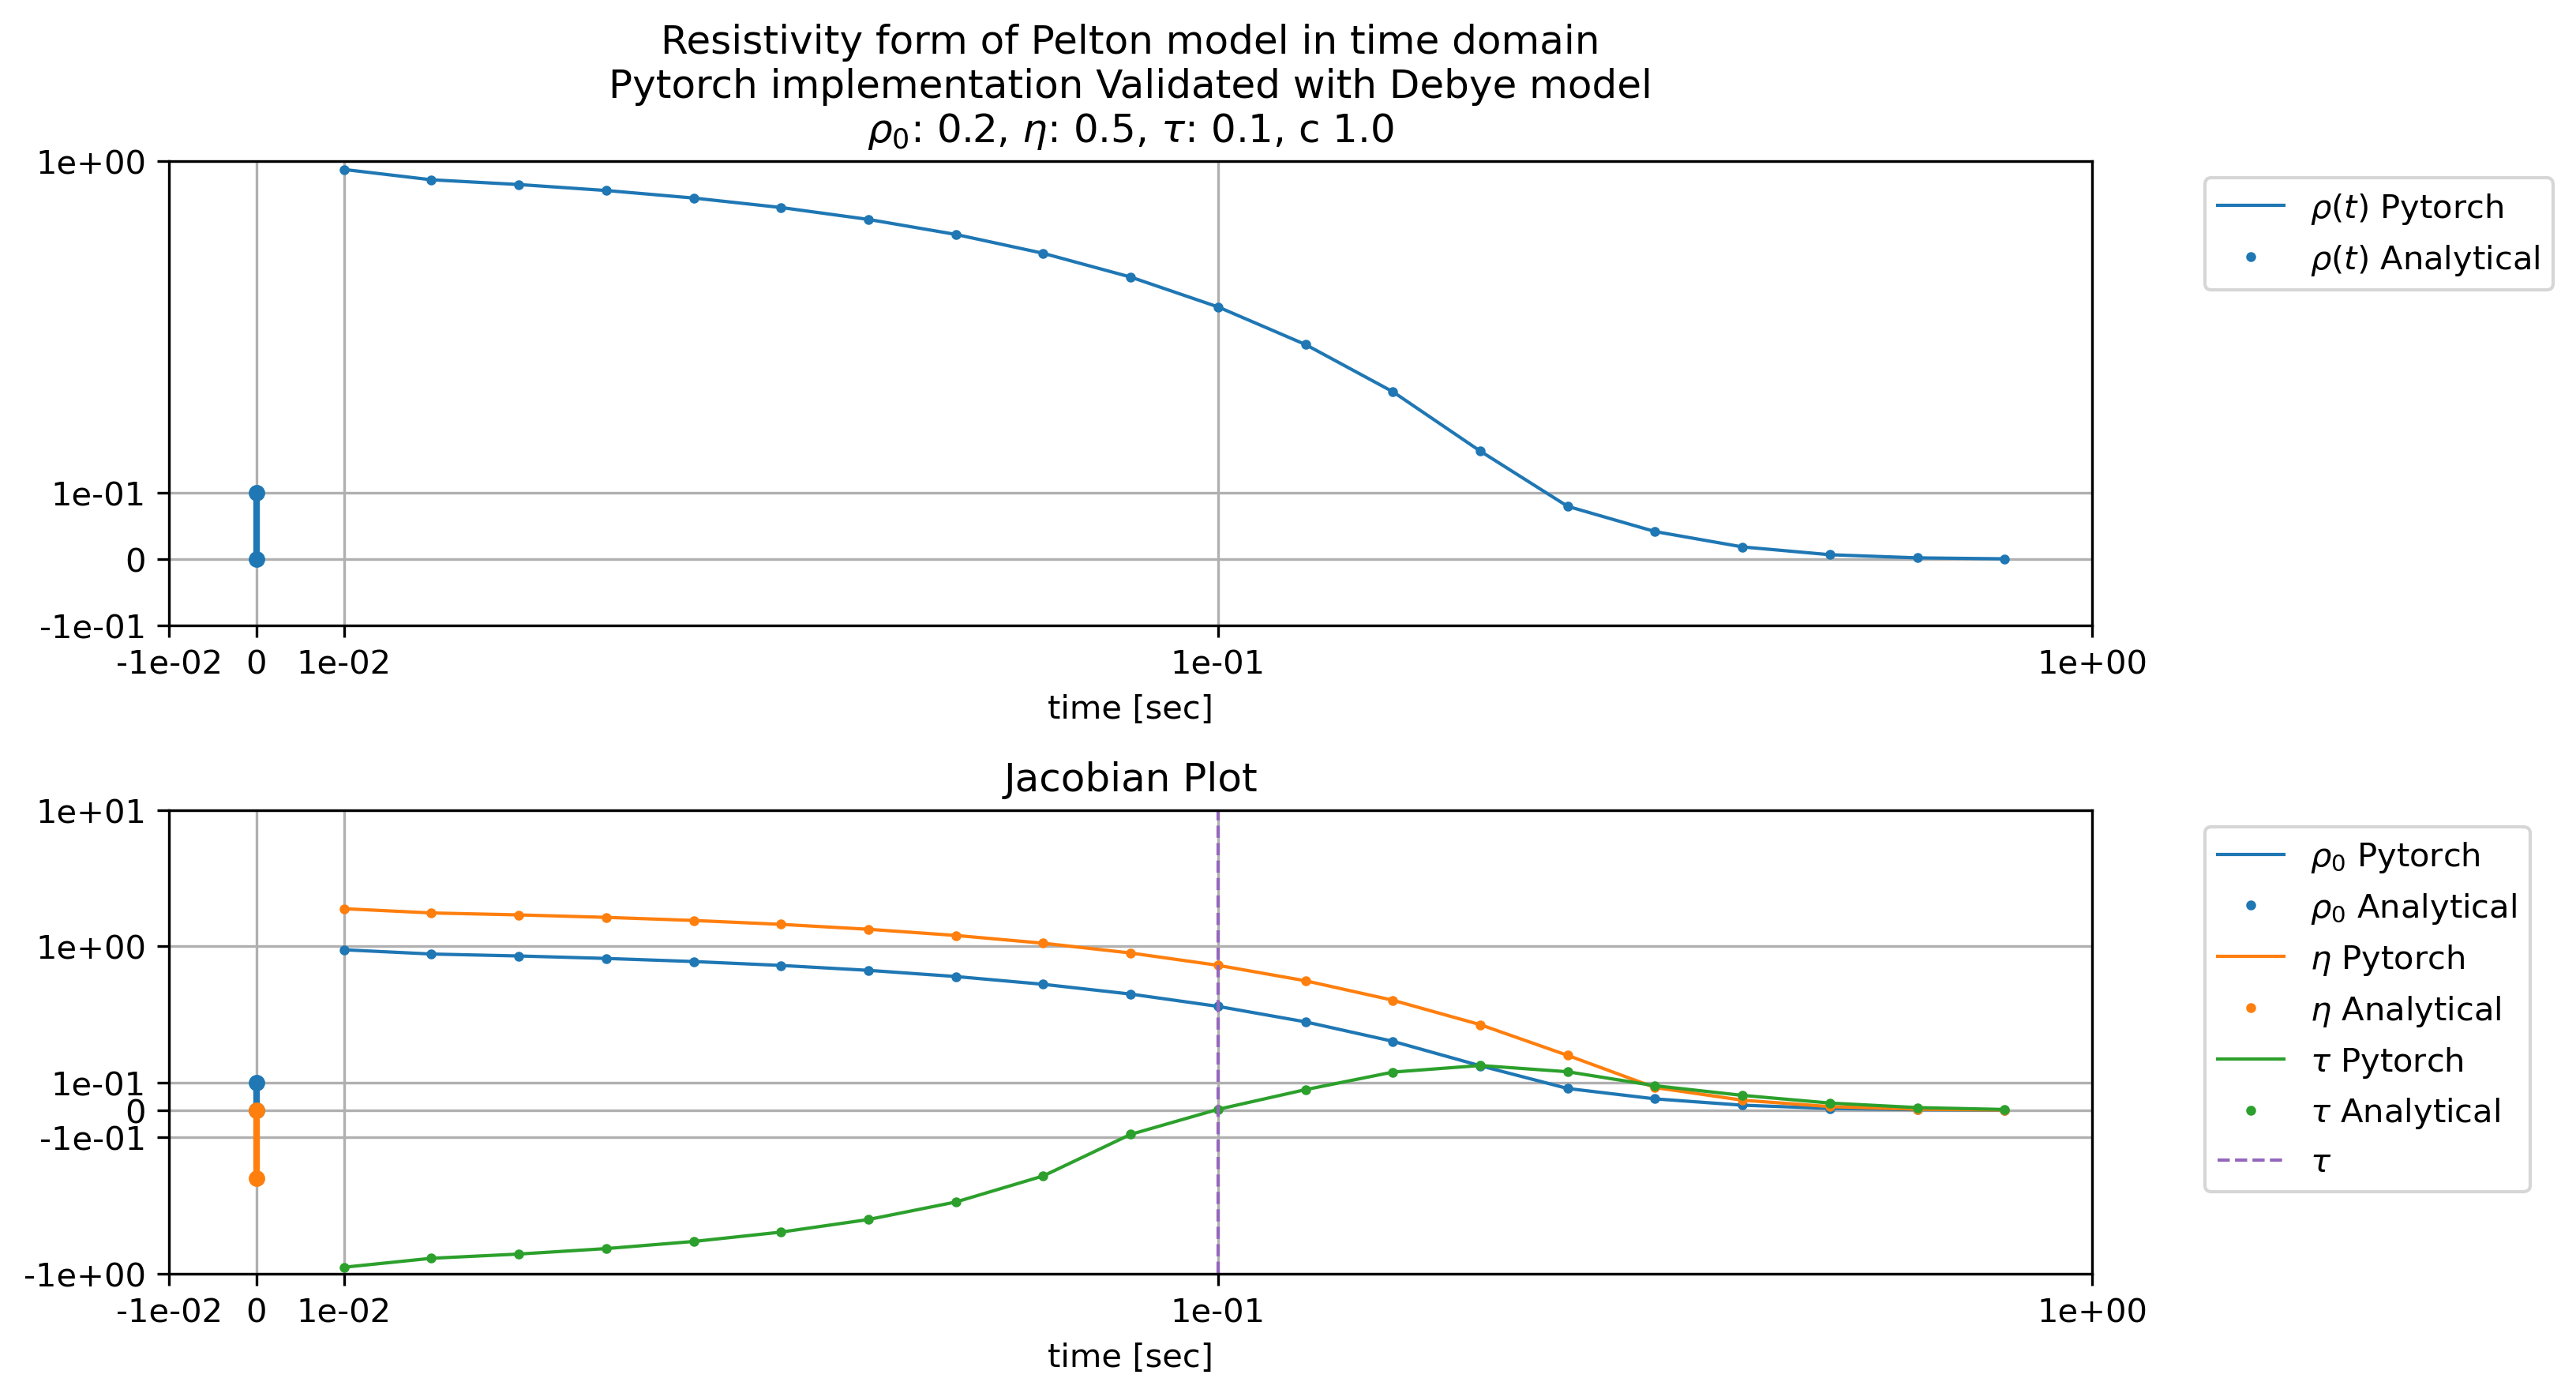

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(11, 6),dpi=300)
ax[0] = PL_pelton.plpl_plot(x=np.r_[0,0], y=np.r_[0,dpred_plot[0]], ax=ax[0], 
                linewidth=2.0,  color="C0") 
ax[0] = PL_pelton.plpl_plot(x=np.r_[0,0], y=np.r_[0, dpred_debye[0] ], ax=ax[0], 
                linestyle="", color="C0", marker='o',  markersize=4) 
ax[0] = PL_pelton.plpl_plot(x=windows_plot[1:], y=dpred_plot[1:], ax=ax[0],
                  color = "C0",label=r"$\rho(t)$ Pytorch")
ax[0] = PL_pelton.plpl_plot(x=windows_plot[1:], y=dpred_debye[1:], ax=ax[0],
                  color = "C0",marker=".",markersize=4,linestyle="",label=r"$\rho(t)$ Analytical")
PL_pelton.pl_axes(ax=ax[0])
PL_pelton.pl_axes_x(ax=ax[0])
ax[1] = PL_jac.plpl_plot(x=np.r_[0,0], y=np.r_[0,J_plot[0,0]], ax=ax[1], 
                linewidth=2.0,  color="C0" ) 
ax[1] = PL_jac.plpl_plot(x=np.r_[0,0], y=np.r_[0,dpred_debye_grad[0,0]], ax=ax[1], 
                linestyle="",  color="C0", marker='o', markersize=4) 
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=J_plot[1:,0], ax=ax[1],
                 color = "C0",label=r"$\rho_0$ Pytorch")
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=dpred_debye_grad[1:,0], ax=ax[1],
        color = "C0",marker=".",markersize=4, linestyle="",
        label=r"$\rho_0$ Analytical")
ax[1] = PL_jac.plpl_plot(x=np.r_[0,0], y=np.r_[0,J_plot[0,1]], ax=ax[1],
                linewidth=2.0, color = "C1")
ax[1] = PL_jac.plpl_plot(x=np.r_[0,0], y=np.r_[0,dpred_debye_grad[0,1],], ax=ax[1],
                linestyle="", color = "C1",marker='o', markersize=4)
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=J_plot[1:,1], ax=ax[1],
                color = "C1",label=r"$\eta$ Pytorch")
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=dpred_debye_grad[1:,1], ax=ax[1],
        color = "C1",marker=".",markersize=4, linestyle="",
        label=r"$\eta$ Analytical")
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=J_plot[1:,2], ax=ax[1],
                color = "C2",label=r"$\tau$ Pytorch")
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=dpred_debye_grad[1:,2], ax=ax[1],
        color = "C2",marker=".",markersize=4, linestyle="",
        label=r"$\tau$ Analytical")
ax[1] = PL_jac.pl_axvline(ax=ax[1], x=tau, color="C4",label=r'$\tau$')
PL_jac.pl_axes(ax=ax[1])
PL_jac.pl_axes_x(ax=ax[1])
for a in ax:
        a.set_xlabel('time [sec]')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title(fr"""Resistivity form of Pelton model in time domain
Pytorch implementation Validated with Debye model
$\rho_0$: {res0}, $\eta$: {eta}, $\tau$: {tau}, c {expc}""")
# ax[0].set_title("Debye model in time domain")
ax[1].set_title('Jacobian Plot')
plt.tight_layout()
plt.savefig("16_AutoDiffValid_TDlP_Debye.jpg", dpi=300)

# Pelton model Conductivity form 

In [17]:
con8 = 5.0
eta= 0.5
tau= 0.1 
expc= 0.5
parm = torch.tensor([np.log(con8), eta, np.log(tau), expc], dtype=torch.float32, requires_grad=True)
ip_model = Pelton_con_f(freq=freq)
sim = InducedPolarizationSimulation(ip_model=ip_model,times=times, mode="sip_t")
print(sim.ip_model)

In [18]:
sim.window_mat = window_mat
sim.windows_strt = windows_strt
sim.windows_end = windows_end
sim.windows_width = windows_end-windows_strt
sim.get_window_matrix()

In [19]:
# logstrt = -4
# logend = 0
# logstep =0.1
# windows_cen = 10**torch.arange(logstrt,logend,logstep)
# #windows_cen = torch.arange(10**logstrt, 10**logend, 1e-4)
# nwindows = windows_cen.shape[0]
# print(windows_cen)
# sim.get_windows(windows_cen)
# print(sim.windows_strt)
# print(sim.windows_end)
# windows_plot = np.r_[0,windows_cen.detach().numpy()]
# print(windows_plot)

In [20]:
dpred = sim.dpred(parm)
dpred_J = sim.J(parm)
dpred_plot= dpred.detach().numpy()
J_plot = dpred_J.detach().numpy()

print(J_plot)

[[ 3.24499781e+05 -1.26234375e+04  1.56573169e+03  2.97178906e+04]
 [-9.85909576e+01 -3.10406952e+02  2.83062935e+01  7.24595947e+01]
 [-2.70546932e+01 -5.90429497e+01  1.23341000e+00 -5.97202225e+01]
 [-2.16246719e+01 -4.40148926e+01  1.91392899e-01 -5.11375847e+01]
 [-1.71377411e+01 -3.22989349e+01 -4.94136035e-01 -4.25588608e+01]
 [-1.34680796e+01 -2.33280888e+01 -9.02026713e-01 -3.44498215e+01]
 [-1.04871941e+01 -1.65506783e+01 -1.10592651e+00 -2.71653290e+01]
 [-8.09752369e+00 -1.15462074e+01 -1.16221225e+00 -2.08452759e+01]
 [-6.19765043e+00 -7.91138935e+00 -1.12097573e+00 -1.55607710e+01]
 [-4.70309830e+00 -5.32296944e+00 -1.02080631e+00 -1.12904272e+01]
 [-3.54092574e+00 -3.52020311e+00 -8.90410006e-01 -7.94387150e+00]
 [-2.64560318e+00 -2.28727913e+00 -7.50979781e-01 -5.40772581e+00]
 [-1.96302199e+00 -1.46202612e+00 -6.16003036e-01 -3.54275012e+00]
 [-1.44736195e+00 -9.19868231e-01 -4.93714303e-01 -2.21596551e+00]
 [-1.06105399e+00 -5.70066929e-01 -3.88010353e-01 -1.30316687e

In [ ]:
sim.count_data_windows(times=sim.times)

tensor([1.0000e+00, 7.4000e+02, 1.9100e+02, 2.4200e+02, 3.0300e+02, 3.8300e+02,
        4.8100e+02, 6.0600e+02, 7.6300e+02, 9.6100e+02, 1.2090e+03, 1.5230e+03,
        1.9160e+03, 2.4130e+03, 3.0380e+03, 3.8240e+03, 4.8140e+03, 6.0610e+03,
        7.6300e+03, 9.6050e+03, 1.0707e+04])

In [30]:
# sim_times = sim.times.detach().numpy()
# sim_times_resmp = torch.tensor(sim_times[1::10])
# print(len(sim_times_resmp))
# sim.get_windows(sim_times_resmp)
# dpred = sim.dpred(parm)
# dpred_J = sim.J(parm)
# dpred_plot= dpred.detach().numpy()
# J_plot = dpred_J.detach().numpy()
# print(J_plot)

In [22]:
dt =(sim.times[1]-sim.times[0]).detach().numpy()
dpred_plot[0] *= dt
J_plot[0,:] *= dt
print(dpred_plot)


[  4.951473   -98.59093    -27.05467    -21.62467    -17.137741
 -13.468091   -10.48719     -8.097527    -6.1976476   -4.7030964
  -3.5409217   -2.6456022   -1.9630197   -1.4473635   -1.0610542
  -0.7740954   -0.5624682   -0.4073795   -0.2943762   -0.2124382
  -0.15592974]


In [23]:
PL_pelton = PsuedoLog(
            logmin=1e0,
            linScale=0.2,
            logminx=10.**np.floor(np.log10(windows_plot[windows_plot>eps].min())),
            linScalex=0.1)
PL_jac = PsuedoLog(
            logmin=1e0,
            linScale=0.2,
            logminx=10.**np.floor(np.log10(windows_plot[windows_plot>eps].min())),
            linScalex=0.1)

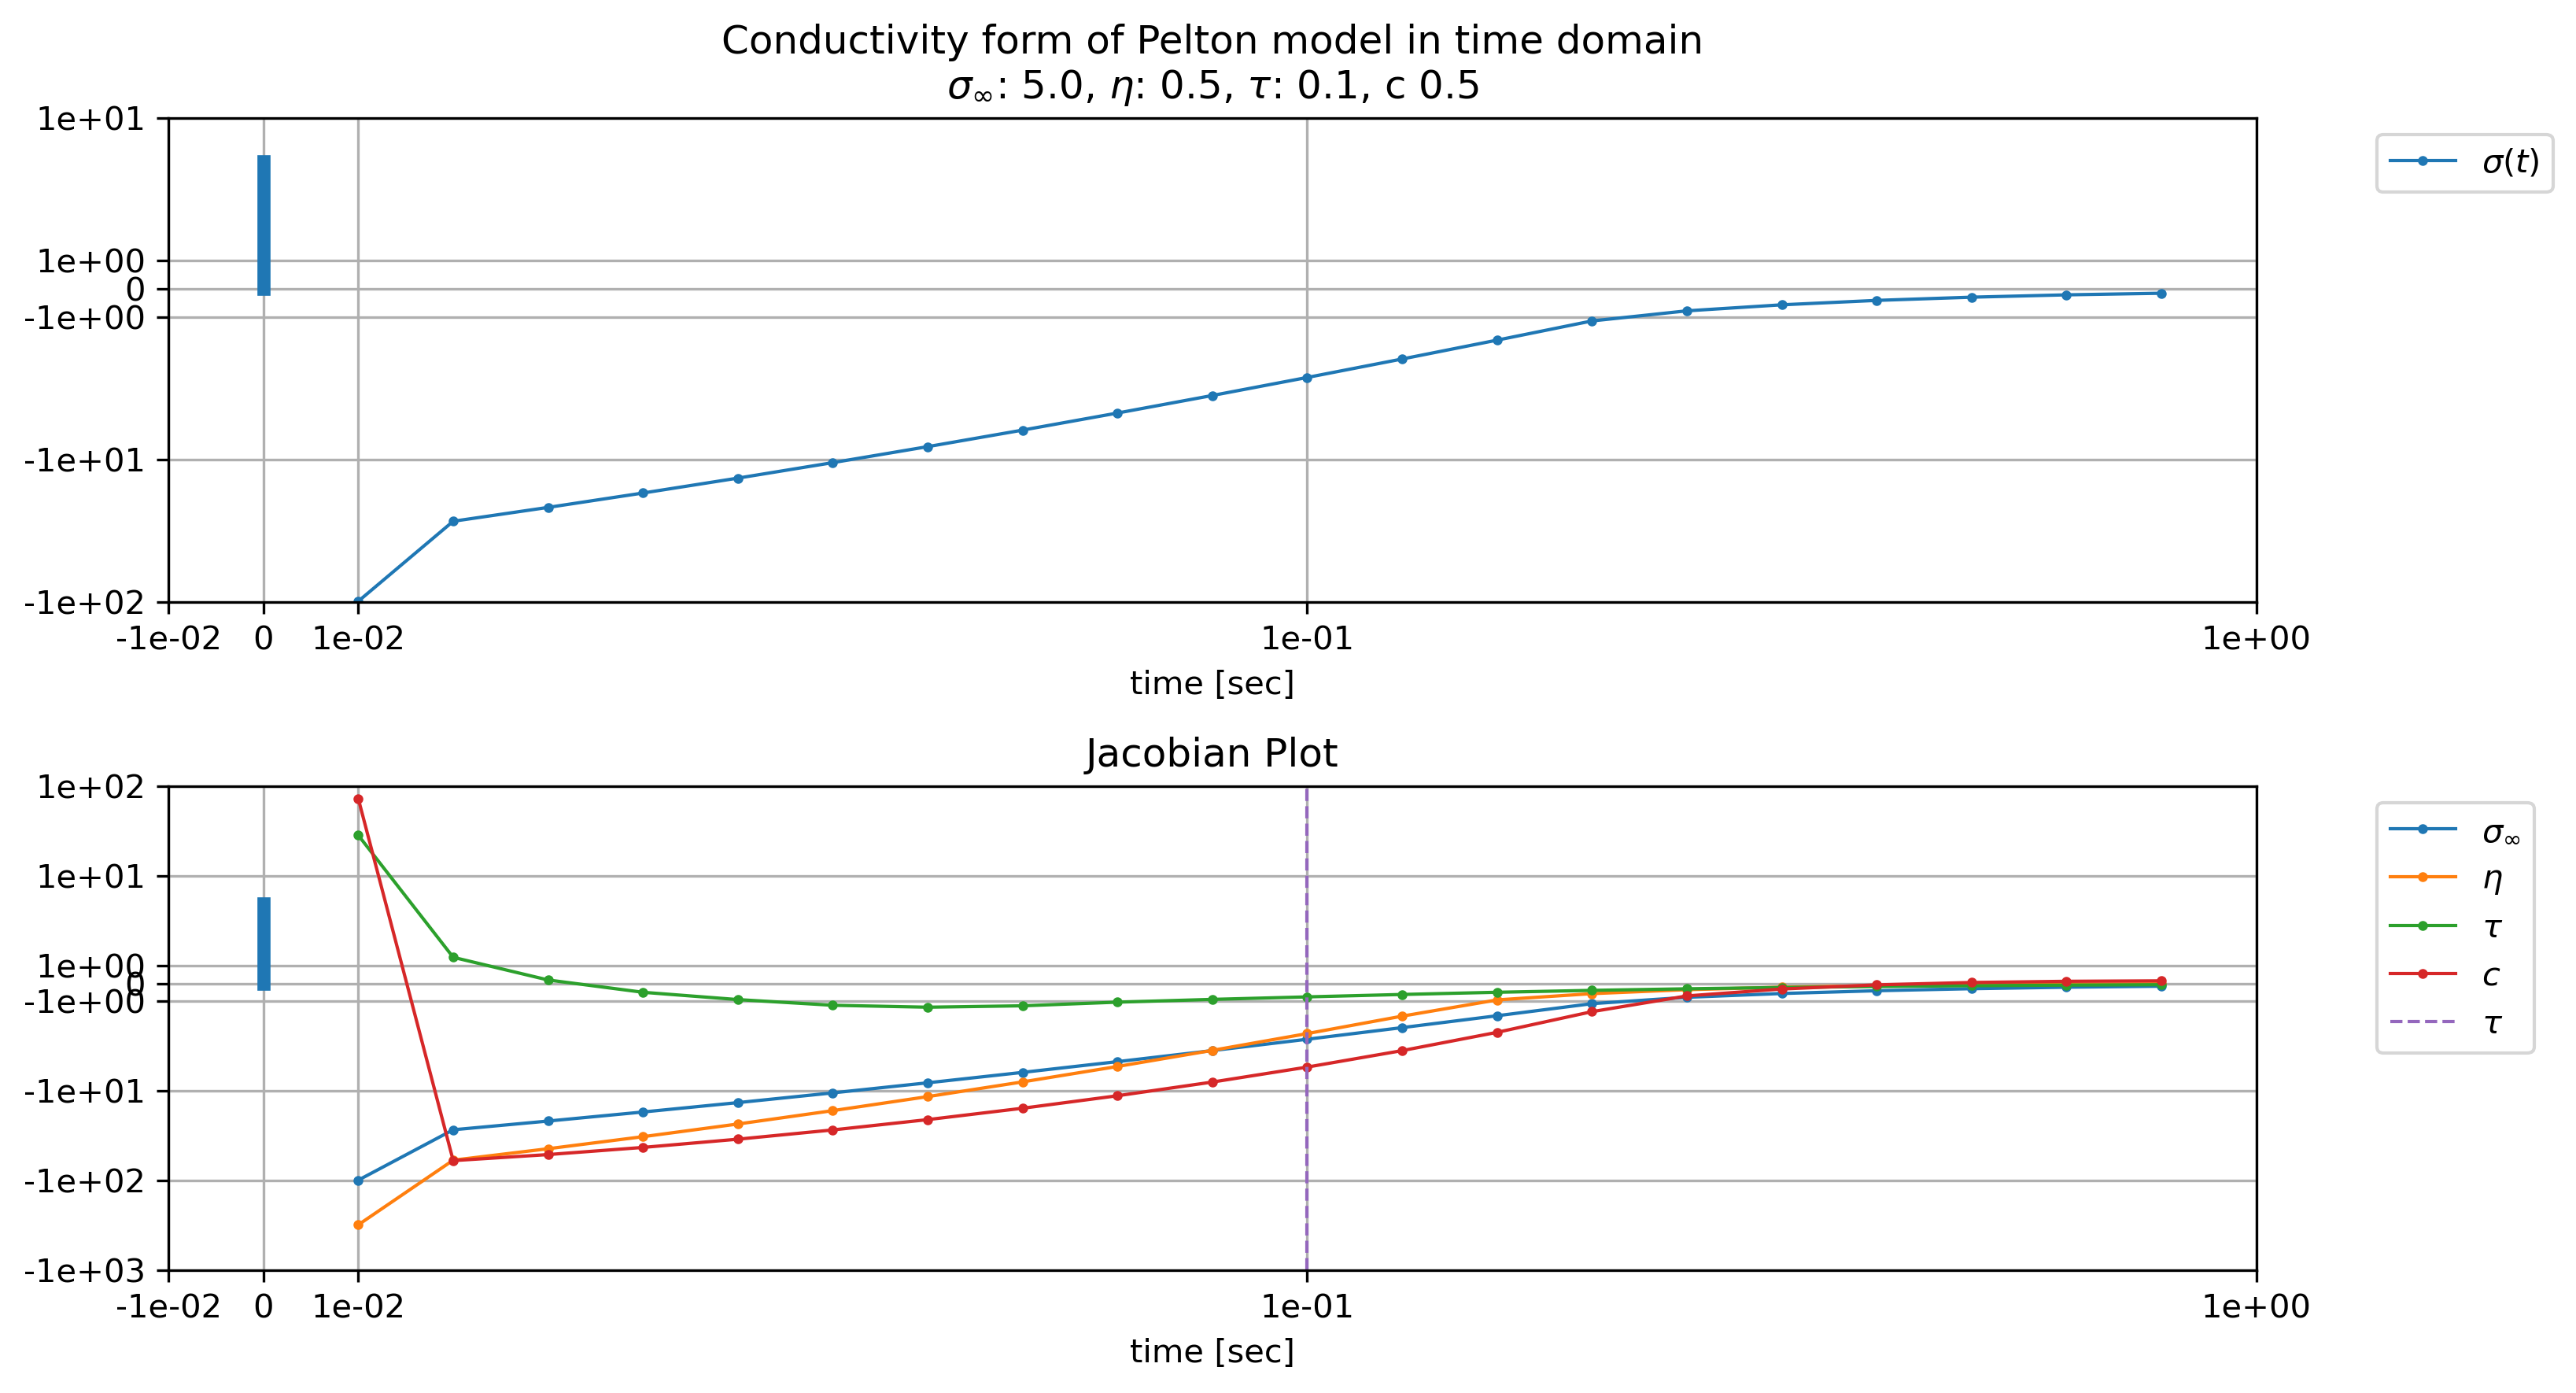

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(11, 6),dpi=300)
ax[0] = PL_pelton.plpl_plot(x=np.r_[0,0], y=np.r_[0,dpred_plot[0]], ax=ax[0], 
                linewidth=4.0,  color="C0") 
ax[0] = PL_pelton.plpl_plot(x=windows_plot[1:], y=dpred_plot[1:], ax=ax[0],
     marker=".",markersize=4.0, color = "C0",label=r"$\sigma(t)$")
PL_pelton.pl_axes(ax=ax[0])
PL_pelton.pl_axes_x(ax=ax[0])
ax[1] = PL_jac.plpl_plot(x=np.r_[0,0], y=np.r_[0,J_plot[0,0]], ax=ax[1], 
                linewidth=4.0,  color="C0" ) 
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=J_plot[1:,0], ax=ax[1],
             marker=".",markersize=4.0,  color = "C0",label=r"$\sigma_\infty$")
# ax[1] = PL_jac.plpl_plot(x=np.r_[0,0], y=np.r_[0,J_plot[0,1]], ax=ax[1],
#                 linewidth=4.0, color = "C1")
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=J_plot[1:,1], ax=ax[1],
   marker=".",markersize=4.0,  color = "C1",label=r"$\eta$")
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=J_plot[1:,2], ax=ax[1],
  marker=".",markersize=4.0,   color = "C2",label=r"$\tau$")
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=J_plot[1:,3], ax=ax[1],
  marker=".",markersize=4.0,   color = "C3",label=r"$c$")
ax[1] = PL_jac.pl_axvline(ax=ax[1], x=tau, color="C4",label=r'$\tau$')

PL_jac.pl_axes(ax=ax[1])
PL_jac.pl_axes_x(ax=ax[1])
for a in ax:
        a.set_xlabel('time [sec]')
#        a.set_ylabel('Amplitude')
        a.grid(which='both')
        a.legend()
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

        # a.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5, frameon=False)
#        plt.tight_layout(rect=[0, 0.1, 1, 1])
ax[0].set_title(fr"""Conductivity form of Pelton model in time domain
$\sigma_\infty$: {con8}, $\eta$: {eta}, $\tau$: {tau}, c {expc}""")
ax[1].set_title('Jacobian Plot')
plt.tight_layout()
plt.savefig("16_AutoDiffValid_TDlP_Pelton_con.jpg", dpi=300)